In [1]:
import numpy as np
import matplotlib.pyplot as plt

from h_general import cudaInfo, reloadLib
from h_videos import collectFiles
from h_json import *
from h_SA import *
from SA_Tree import *
from h_CLIP import *

p = 5
plt.rcParams['figure.figsize'] = [p,p]

In [21]:
!pwd

/home/dkhatanassia/segment-anything


In [2]:
online =True
if online:
    # path to data/annotations in "system" format
    syspath="/home/dkhatanassia/detectron2_dataset"

    #*************************************** datasets *****************************************
    dataset_train = 'jerry_real'
    dataset_test = 'jerry_real'
    DPI = 50
    #******************************************************************************************

    # root
    root_train = join(syspath,dataset_train)
    root_test = join(syspath,dataset_test)

    # path to images{train, test}
    imgs_train = join(root_train,'imgs')
    imgs_test = join(root_test,'_imgs')

    # path to json{train, test}
    json_name_GT = f'GT_{dataset_test}.json'
    json_name_GT_tr = f'tr_GT_{dataset_train}.json'
    json_name_GT_te = f'te_GT_{dataset_test}.json'
    json_name_mc = f'mc_{dataset_test}.json'
    json_name_mc_tr = f'tr_mc_{dataset_train}.json'
    json_name_mc_te = f'te_mc_{dataset_test}.json'

    json_path_GT = join(root_test,'annotations',json_name_GT)
    json_path_GT_tr = join(root_train,'annotations',json_name_GT_tr)
    json_path_GT_te = join(root_test,'annotations',json_name_GT_te)
    json_path_mc = join(root_test,'annotations',json_name_mc)
    json_path_mc_tr = join(root_train,'annotations',json_name_mc_tr)
    json_path_mc_te = join(root_test,'annotations',json_name_mc_te)
    
else: 
    imgs_test= '/home/dkhatanassia/drives/Gdrive/notShared/python/data/jerrycans/SA_frog'

In [3]:
images = collectFiles([imgs_test])
cudaInfo()

|===========================================================================|
|                  PyTorch CUDA memory summary, device ID 0                 |
|---------------------------------------------------------------------------|
|            CUDA OOMs: 0            |        cudaMalloc retries: 0         |
|===========================================================================|
|        Metric         | Cur Usage  | Peak Usage | Tot Alloc  | Tot Freed  |
|---------------------------------------------------------------------------|
| Allocated memory      |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |      0 B   |
|       from small pool |      0 B   |      0 B   |      0 B   |      0 B   |
|---------------------------------------------------------------------------|
| Active memory         |      0 B   |      0 B   |      0 B   |      0 B   |
|       from large pool |      0 B   |      0 B   |      0 B   |

## CutLER

In [4]:
cutler_path = join('/home/dkhatanassia/detectron2_dataset/jerry_real/00_improve/aftersp10/success_infty/rd4-5','te_jerry_real_rd5_DPI50_th0.95.json')

jsn_cl = readJson(cutler_path)
anns_cl = jsn_cl['annotations']
anns_cl = decodeMasks(anns_cl)

# compute stats
cl_areas = np.array([bboxArea(d) for d in anns_cl])
cl_median = np.median(cl_areas)
cl_mean = cl_areas.mean()
cl_std = cl_areas.std()
cl_median,cl_mean,cl_std

# image of test set
img_te_id = list(set([i['image_id'] for i in jsn_cl['annotations']]))
sorted([i for i in img_te_id])[:10]

[3, 4, 5, 13, 15, 19, 26, 31, 37, 45]

#### Load img

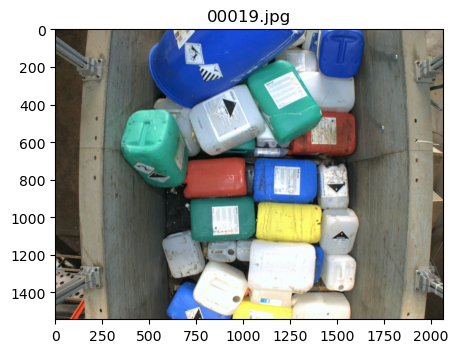

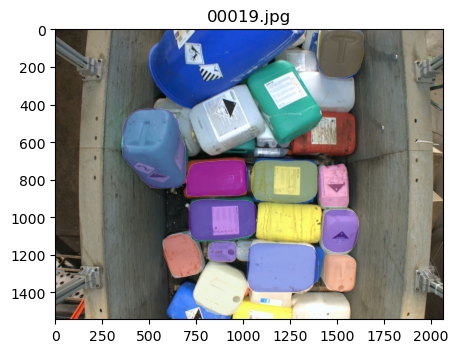

In [5]:
id = 368
id = 19
image_path = [im for im in images if str(id).zfill(5) in im][0]
image_title = image_path.split('/')[-1]

image = cv2.imread(image_path)
image = image[:,:,::-1]
img_anns_cl = [i for i in jsn_cl['annotations'] if i['image_id'] == id]

visualizeSA(image,title = image_title,axis='on')
visualizeSA(image,[i for i in jsn_cl['annotations'] if i['image_id'] == id],title = image_title,axis='on')

## SA: Automatic mask generation (SamAutomaticMaskGenerator)

dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


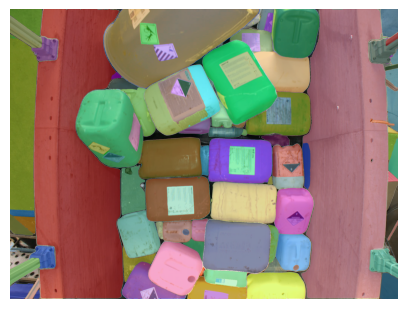

In [6]:
mask_generator = SamAutomaticMaskGenerator(initSam())
masks = mask_generator.generate(image)
#masks = cleanMasks(masks)
print(masks[0].keys())

visualizeSA(image,masks)

In [7]:
masks[0]

{'segmentation': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]]),
 'area': 113855,
 'bbox': [350, 428, 357, 416],
 'predicted_iou': 1.0292474031448364,
 'point_coords': [[483.75, 554.875]],
 'stability_score': 0.9891317486763,
 'crop_box': [0, 0, 2064, 1544]}

## CutLER x SA

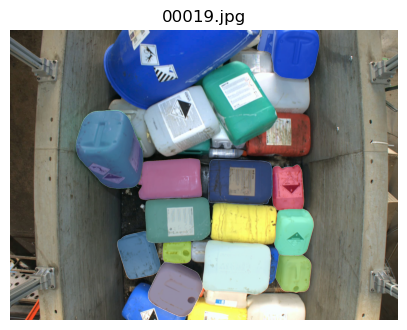

In [14]:
modified = replaceAnnotations(img_anns_cl,masks)
visualizeSA(image,modified,title=image_title)

## SA + TreesOfTrash (to be continued)

In [18]:
are_overlapping = maskOverlay2(masks)
buildForest(masks, are_overlapping)

is_a_match = matchingAnnotations(img_anns_cl,masks)
is_a_match = [i[1] for i in is_a_match]
is_a_match

bad_children = []
bad_parents = []
for i in is_a_match:
    bad_children += Tree.get(i).getChildren()
    bad_parents += Tree.get(i).getAncestors()
    
print('Good masks: {0}\n'
      'bad children: {1}\n'
      'bad parents: {2}'.format(
          is_a_match,
          bad_children,
          bad_parents))

IndexError: list index out of range

In [16]:
def cropMaskNo(image, mask):
    tmp = image.copy()
    tmp[~mask['segmentation']]=0
    return tmp

i = 10
Tree.get(i).info()
showLoc(image,masks[i])
cropped = cropMask(image,masks[i])
plt.imshow(cropped)
plt.axis('off')

Node 10 does not exist


AttributeError: 'NoneType' object has no attribute 'info'

## CLIP

In [8]:
import clip
from PIL import Image

clip.available_models()
clp = initCLIP()

In [9]:
objects = [
    ["beam", "wall","structural element"],
    ["pipe (fluid conveyance)",],
    ['bottle', "cap"],
    ['jerrycan'],
    ['label',"sticker"],
]
material = ["metal", "plastic"]

categories = [
    f'part of a "{o}" on a black backround' 
    for j in range(len(objects)) 
    for o in objects[j]]

#obj += [f'{pre} made of {m}' for pre in obj for m in material]
#obj = [f'a {color} colored item, on a black background' for color in ['yellow','black','red','green','blue','white']]

categories += ['it is not clear what the picture shows']

categories

['part of a "beam" on a black backround',
 'part of a "wall" on a black backround',
 'part of a "structural element" on a black backround',
 'part of a "pipe (fluid conveyance)" on a black backround',
 'part of a "bottle" on a black backround',
 'part of a "cap" on a black backround',
 'part of a "jerrycan" on a black backround',
 'part of a "label" on a black backround',
 'part of a "sticker" on a black backround',
 'it is not clear what the picture shows']

#### Plug and play image to text

In [10]:
masks_clip = []
embeddings = []
for i in masks:
    cropped = cropMask(image,i,10)
    results,cat,_ = computeScore(cropped,categories,clp)
    embeddings.append(getEmbedding(cropped,clp))
    if False or ("jerrycan" in categories[np.argmax(results)]): #results.max()>0.8 or
        #print(obj[np.argmax(results)], results.max())
        #showLoc(image,i)
        masks_clip.append(i)
        
len(masks_clip)

0

In [19]:
writeJson('deleteme.json',embeddings[0].astype(float).tolist())

In [20]:
np.array(readJson('deleteme.json'),dtype=np.float16) == embeddings[0]

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

In [ ]:
for i in range(65,85,1):
    showLoc(image,masks[i])
    print(i)

#### dummy cosine similarity is useless

In [22]:
def cosine_similarity(tensor1, tensor2):
    tensor1=tensor1.detach().cpu().numpy().squeeze()
    tensor2=tensor2.detach().cpu().numpy().squeeze()
    dot_product = np.dot(tensor1, tensor2.T)
    norm1 = np.linalg.norm(tensor1)
    norm2 = np.linalg.norm(tensor2)
    cosine_similarity = dot_product / (norm1 * norm2)
    return cosine_similarity

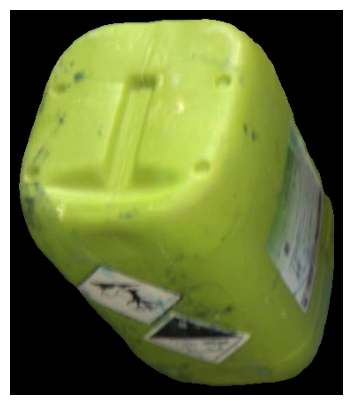

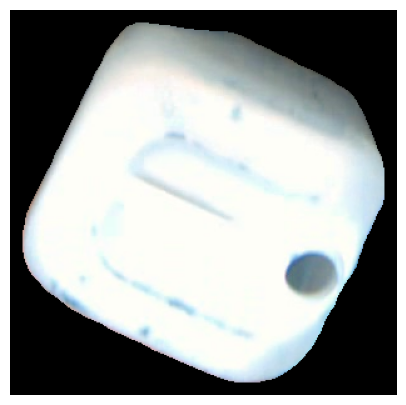

0.8013


In [48]:
cropped = cropMask(image,masks[0],10)
plt.imshow(cropped)
plt.axis('off')
plt.show()
results,embedding1 = computeScore(cropped,categories,clp)

cropped = cropMask(image,masks[2],10)
plt.imshow(cropped)
plt.axis('off')
plt.show()
results,embedding2 = computeScore(cropped,categories,clp)

print(cosine_similarity(embedding1,embedding2))

In [82]:
buildForest(masks,are_overlapping)
th_clip = 0.7
#th_area = 0.5*cl_mean
#smaller_than = [Tree.cut(i) for i in Tree.existing_idx if bboxArea(masks[i])<th_area]

token = True
while token:
    heads_of_tree = Tree.heads()
    token = False 
    new_heads=[]
    for head in heads_of_tree:
        # head composed of several instances
        if Tree.get(head).composed and computeScore(head)>=th_clip and all([computeScore(i)>=th_clip for i in Tree.get(head).children]):
            new_heads+=Tree.get(head).children
            Tree.cut(head)
            token = True
            
        # parent no good
        elif computeScore(head)<th_clip:
            Tree.cut(head)
            token = True
            
        elif all([computeScore(i)>=th_clip for i in Tree.get(head).children]):
            Tree.cut(head)
            token = True
            
new_heads = Tree.heads()


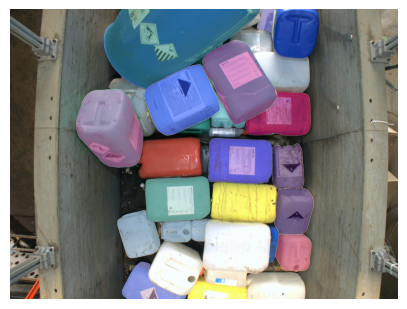

In [83]:
plt.figure()
plt.imshow(image)
show_anns([i for idx,i in enumerate(masks) if idx in new_heads])
plt.axis('off')
plt.show()

### Stuff


In [ ]:
def singleFromPrompt(masks,i):
    prompts = np.array([i['point_coords'] for i in masks]).squeeze()
    bool_mask = np.logical_and(prompts[:,0]==prompts[i,0],prompts[:,1]==prompts[i,1])
    return True if bool_mask.sum()==1 else False

def fromSamePrompt(masks, i):
    prompts = np.array([i['point_coords'] for i in masks]).squeeze()
    bool_mask = np.logical_and(prompts[:,0]==prompts[i,0],prompts[:,1]==prompts[i,1])
    return np.where(bool_mask==True)[0]


from_same_prompt=[]
seen = []
for i in range(len(masks)):
    if i in seen: continue
    elif singleFromPrompt(masks,i): seen.append(i)
    else: 
        output = fromSamePrompt(masks,i)
        for j in output: seen.append(j)
        from_same_prompt.append(output)

from_same_prompt

In [ ]:
prompts = np.array([i['point_coords'][0] for i in masks])

plt.figure(figsize=(p,p))
plt.title(img)
plt.imshow(image)
show_points(prompts,np.ones(len(prompts)),plt.gca())
plt.axis('on')
plt.show()

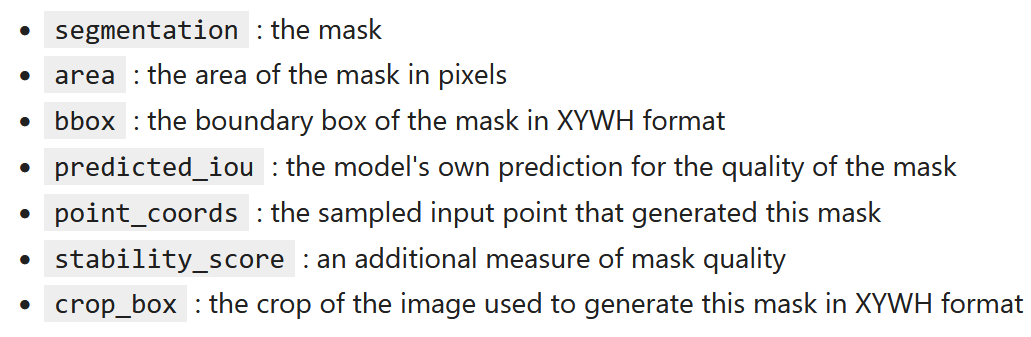

##### adding options

In [13]:
mask_generator_2 = SamAutomaticMaskGenerator(
    model=initSam(),
    points_per_side=64,
    points_per_batch=4
)

torch.cuda.empty_cache()

154
dict_keys(['segmentation', 'area', 'bbox', 'predicted_iou', 'point_coords', 'stability_score', 'crop_box'])


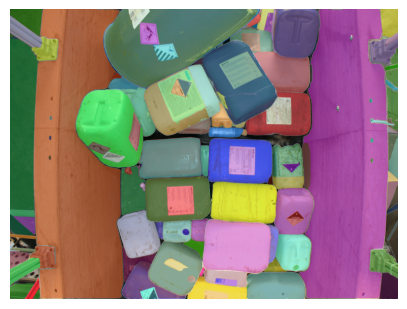

In [14]:
masks = mask_generator_2.generate(image)
print(len(masks))
print(masks[0].keys())

plt.figure()
plt.imshow(image)
show_anns(masks)
plt.axis('off')
plt.show()

del masks

In [312]:
from pycocotools import mask as maskUtils
import sys
import copy

def encodeMasks(masks):
    tojson = copy.deepcopy(masks)
    for i in range(len(masks)):
        tojson[i]['segmentation'] = maskUtils.encode(np.asfortranarray(masks[i]['segmentation']))
        
    return tojson

tojson = encodeMasks(masks)

In [314]:
def singleFromPrompt(masks,i):
    prompts = np.array([i['point_coords'] for i in masks]).squeeze()
    bool_mask = np.logical_and(prompts[:,0]==prompts[i,0],prompts[:,1]==prompts[i,1])
    return True if bool_mask.sum()==1 else False

def fromSamePrompt(masks, i):
    prompts = np.array([i['point_coords'] for i in masks]).squeeze()
    bool_mask = np.logical_and(prompts[:,0]==prompts[i,0],prompts[:,1]==prompts[i,1])
    return np.where(bool_mask==True)[0]


from_same_prompt=[]
seen = []
for i in range(len(masks)):
    if i in seen: continue
    elif singleFromPrompt(masks,i): seen.append(i)
    else: 
        output = fromSamePrompt(masks,i)
        for j in output: seen.append(j)
        from_same_prompt.append(output)

from_same_prompt

[array([ 2, 13]),
 array([ 5, 10]),
 array([ 6, 12]),
 array([ 16, 161]),
 array([ 17, 163]),
 array([ 27, 165]),
 array([32, 39]),
 array([33, 37]),
 array([49, 51]),
 array([50, 55]),
 array([56, 60]),
 array([69, 78]),
 array([71, 73]),
 array([ 77, 169]),
 array([80, 82]),
 array([ 98, 174]),
 array([109, 110]),
 array([136, 189]),
 array([140, 150])]

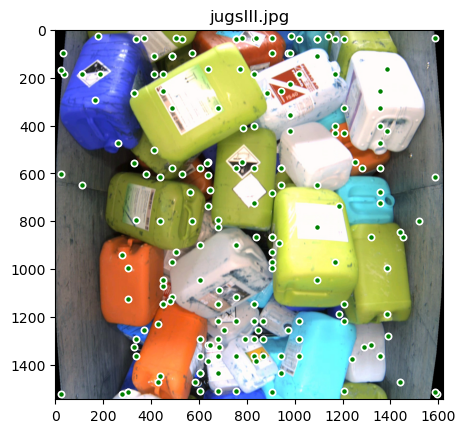

In [300]:
prompts = np.array([i['point_coords'][0] for i in masks])

plt.figure(figsize=(p,p))
plt.title(img)
plt.imshow(image)
show_points(prompts,np.ones(len(prompts)),plt.gca())
plt.axis('on')
plt.show()

In [ ]:
def belongsTo(mask1, mask2):
    # area of smallest mask
    smallest_area = mask1['area'] if mask1['area']<mask2['area'] else mask2['area']
    
    segm1 = mask1['segmentation']
    segm2 = mask2['segmentation']
    
    rle = maskUtils.encode(np.asfortranarray(np.logical_and(segm1,segm2)))
    area = int(maskUtils.area(rle))

    return True if smallest_area > 0.99*area else False

In [ ]:
def displayPixelCount(masks):
    for idx,m in enumerate(masks):
        tmp = label(m['segmentation'])
        if tmp.max()>1:
            print(idx,':',[(i,(tmp==i).sum()) for i in range(len(np.unique(tmp)))])
            
displayPixelCount(masks)

#### Prompt (SamPredictor)

embedding.shape=(1, 256, 64, 64)


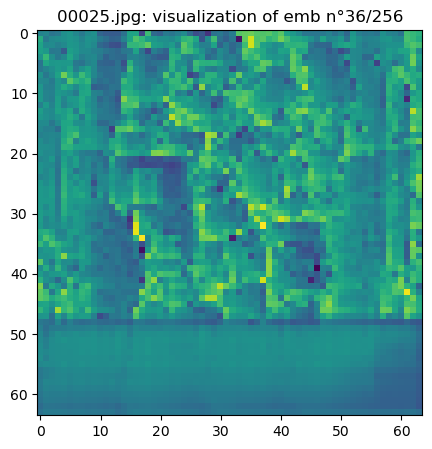

In [9]:
predictor = SamPredictor(sam)
predictor.set_image(image)
predictor.get_image_embedding().cpu().numpy().shape
print(f'embedding.shape={predictor.get_image_embedding().cpu().numpy().shape}')

emb_nb = 35
test = predictor.get_image_embedding().cpu().numpy().squeeze()[emb_nb,:,:]

plt.imshow(test)
plt.title(f'{image_title}: visualization of emb n°{emb_nb+1}/256')
plt.show()